# Curriculum Mapping: LDA and NER Implementation
## Mapping UT Austin School of Nursing BSN Curriculum to AACN Competencies


## 1. Installing Packages and Dependencies


In [1]:
!pip install -q scikit-learn nltk spacy pandas numpy scipy
!pip install -q scispacy

!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz (14.8 MB)
  Preparing metadata (setup.py) ... done


In [2]:
import json
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)


True

## 2. Data Loading and Preprocessing

In [4]:
with open('syllabi.json', 'r') as f:
    syllabi_data = json.load(f)


10 AACN Domains

In [ ]:
# 10 aacn domains
import re

aacn_domains_raw = [
    {
        "domain_id": 1,
        "domain_name": "Knowledge for Nursing Practice",
        "description": "Integration, synthesis, and application of knowledge from arts, sciences, humanities, public health, quality improvement, and organizational sciences for safe, quality nursing practice.",
        "competencies": [
            "Demonstrate an understanding of the discipline of nursing's distinct perspective and where shared perspectives exist with other disciplines",
            "Apply theory and research-based knowledge from nursing, the arts, humanities, and other sciences",
            "Demonstrate clinical judgment founded on a broad knowledge base"
        ]
    },
    {
        "domain_id": 2,
        "domain_name": "Person-Centered Care",
        "description": "Focuses on the individual within multiple complicated contexts, including family and/or important others, establishing caring relationships and coordinating care.",
        "competencies": [
            "Engage with the individual in establishing a caring relationship",
            "Communicate effectively with individuals",
            "Integrate assessment skills in practice",
            "Diagnose actual or potential health problems and needs",
            "Develop a plan of care",
            "Demonstrate accountability for care delivery",
            "Evaluate outcomes of care",
            "Promote self-care management",
            "Provide care coordination"
        ]
    },
    {
        "domain_id": 3,
        "domain_name": "Population Health",
        "description": "Span of healthcare delivery from public health prevention to disease management of populations, including advocacy and disaster preparedness.",
        "competencies": [
            "Manage population health",
            "Engage in effective partnerships",
            "Consider the socioeconomic impact of the delivery of health care",
            "Advance equitable population health policy",
            "Demonstrate advocacy strategies",
            "Advance preparedness to protect population health during disasters and public health emergencies"
        ]
    },
    {
        "domain_id": 4,
        "domain_name": "Scholarship for the Nursing Discipline",
        "description": "Generation, synthesis, translation, application, and dissemination of nursing knowledge to improve health and transform health care.",
        "competencies": [
            "Advance the scholarship of nursing",
            "Integrate best evidence into nursing practice",
            "Promote the ethical conduct of scholarly activities"
        ]
    },
    {
        "domain_id": 5,
        "domain_name": "Quality and Safety",
        "description": "Minimizing risk of harm to patients and providers through both system effectiveness and individual performance.",
        "competencies": [
            "Apply quality improvement principles in care delivery",
            "Contribute to a culture of patient safety",
            "Contribute to a culture of provider and work environment safety"
        ]
    },
    {
        "domain_id": 6,
        "domain_name": "Interprofessional Partnerships",
        "description": "Intentional collaboration across professions and with care team members, patients, families, and communities to optimize care.",
        "competencies": [
            "Communicate in a manner that facilitates a partnership approach to quality care delivery",
            "Perform effectively in different team roles, using principles and values of team dynamics",
            "Use knowledge of nursing and other professions to address healthcare needs",
            "Work with other professions to maintain a climate of mutual learning, respect, and shared values"
        ]
    },
    {
        "domain_id": 7,
        "domain_name": "Systems-Based Practice",
        "description": "Responding to and influencing the larger context of health care, including the organization and financing of health care.",
        "competencies": [
            "Apply knowledge of systems to work effectively across the continuum of care",
            "Incorporate consideration of cost-effectiveness of care",
            "Optimize system effectiveness through application of innovation and evidence-based practice"
        ]
    },
    {
        "domain_id": 8,
        "domain_name": "Informatics and Healthcare Technologies",
        "description": "Use of information and technology to communicate, manage knowledge, mitigate error, and support decision making.",
        "competencies": [
            "Describe the various information and communication technology tools used in the care of patients, communities, and populations",
            "Use information and communication technology to gather data, create information, and generate knowledge",
            "Use information and communication technologies and informatics processes to deliver safe nursing care to diverse populations",
            "Use information and communication technology to support documentation of care and communication among providers, patients, and all system levels",
            "Use information and communication technologies in accordance with ethical, legal, professional, and regulatory standards"
        ]
    },
    {
        "domain_id": 9,
        "domain_name": "Professionalism",
        "description": "Formation and cultivation of a sustainable professional identity involving accountability, ethics, and values.",
        "competencies": [
            "Demonstrate an ethical comportment in one's practice reflective of nursing's mission to society",
            "Employ participatory approach to nursing care",
            "Demonstrate accountability to the individual, society, and the profession",
            "Comply with relevant laws, policies, and regulations",
            "Demonstrate the professional identity of nursing",
            "Integrate diversity, equity, and inclusion as core to one's professional identity"
        ]
    },
    {
        "domain_id": 10,
        "domain_name": "Personal, Professional, and Leadership Development",
        "description": "Participation in activities that contribute to lifelong learning and leadership development to improve nursing practice.",
        "competencies": [
            "Demonstrate a commitment to personal health and well-being",
            "Demonstrate a spirit of inquiry that fosters flexibility and professional maturity",
            "Develop capacity for leadership"
        ]
    }
]

aacn_domains = aacn_domains_raw

for domain in aacn_domains:
    print(f"  {domain['domain_id']}. {domain['domain_name']} ({len(domain['competencies'])} competencies)")

  1. Knowledge for Nursing Practice (3 competencies)
  2. Person-Centered Care (9 competencies)
  3. Population Health (6 competencies)
  4. Scholarship for the Nursing Discipline (3 competencies)
  5. Quality and Safety (3 competencies)
  6. Interprofessional Partnerships (4 competencies)
  7. Systems-Based Practice (3 competencies)
  8. Informatics and Healthcare Technologies (5 competencies)
  9. Professionalism (6 competencies)
  10. Personal, Professional, and Leadership Development (3 competencies)


In [6]:
# function to extract course syllabi text
def extract_course_text(course):
    text_parts = []

    if 'course_name' in course:
        text_parts.append(course['course_name'])

    if 'learning_objectives' in course and course['learning_objectives']:
        if isinstance(course['learning_objectives'], list):
            text_parts.extend(course['learning_objectives'])
        else:
            text_parts.append(str(course['learning_objectives']))

    if 'learning_outcomes' in course and course['learning_outcomes']:
        if isinstance(course['learning_outcomes'], list):
            text_parts.extend(course['learning_outcomes'])
        else:
            text_parts.append(str(course['learning_outcomes']))

    return ' '.join(text_parts)

courses = []
for course in syllabi_data:
    courses.append({
        'course_code': course.get('course_code', 'UNKNOWN'),
        'course_name': course.get('course_name', 'Unknown Course'),
        'text': extract_course_text(course)
    })

print(courses[0]['text'][:200] + "...")

Capstone Preceptorship Provide care for multiple clients and their families through direct care and delegation of care to other members of the health care team. Prioritize and carry out nursing aspect...


In [7]:
# function to extract domain text
def extract_domain_text(domain):
    """
    Extract and combine text from AACN domain description and competencies.
    """
    text_parts = []

    text_parts.append(domain.get('domain_name', ''))
    text_parts.append(domain.get('description', ''))

    if 'competencies' in domain and domain['competencies']:
        if isinstance(domain['competencies'], list):
            text_parts.extend(domain['competencies'])
        else:
            text_parts.append(str(domain['competencies']))

    return ' '.join(text_parts)

domains = []
for domain in aacn_domains:
    domains.append({
        'domain_id': domain.get('domain_id'),
        'domain_name': domain.get('domain_name'),
        'text': extract_domain_text(domain)
    })

print(f"Extracted text from {len(domains)} domains")

Extracted text from 10 domains


## 3. Method 1: LDA (Latent Dirichlet Allocation)

In [8]:
class LDAMapper:
    def __init__(self, n_topics=15, random_state=42):
        self.n_topics = n_topics
        self.random_state = random_state
        self.vectorizer = None
        self.lda_model = None
        self.course_topic_dist = None
        self.domain_topic_dist = None

    def preprocess_text(self, text):
        # lowercase and tokenize
        tokens = word_tokenize(text.lower())

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [t for t in tokens if t.isalpha() and len(t) > 2 and t not in stop_words]

        return ' '.join(tokens)

    def fit(self, course_texts, domain_texts):
        all_texts = [self.preprocess_text(t) for t in course_texts + domain_texts]

        # creating doucment matrix
        self.vectorizer = CountVectorizer(
            max_features=500,
            min_df=2,
            max_df=0.8,
            ngram_range=(1, 2)
        )
        dtm = self.vectorizer.fit_transform(all_texts)

        self.lda_model = LatentDirichletAllocation(
            n_components=self.n_topics,
            random_state=self.random_state,
            max_iter=20,
            learning_method='batch'
        )

        topic_distributions = self.lda_model.fit_transform(dtm)

        # split distributions into courses and domains
        n_courses = len(course_texts)
        self.course_topic_dist = topic_distributions[:n_courses]
        self.domain_topic_dist = topic_distributions[n_courses:]

        return self

    def get_topic_words(self, n_words=10):
        feature_names = self.vectorizer.get_feature_names_out()
        topics = {}

        for topic_idx, topic in enumerate(self.lda_model.components_):
            top_indices = topic.argsort()[-n_words:][::-1]
            top_words = [feature_names[i] for i in top_indices]
            topics[f"Topic_{topic_idx}"] = top_words

        return topics

    def predict(self, course_idx, top_k=3):
        course_dist = self.course_topic_dist[course_idx]

        similarities = []
        for domain_idx, domain_dist in enumerate(self.domain_topic_dist):
            # calculate JS divergence
            js_div = jensenshannon(course_dist, domain_dist)

            # similarity score is 1 - divergence
            similarity = 1 - js_div

            similarities.append((domain_idx, js_div, similarity))

        similarities.sort(key=lambda x: x[2], reverse=True)

        return similarities[:top_k]

    def predict_all(self, course_codes, domain_ids, top_k=3):
        # predict domains on remaing corpus
        predictions = {}

        for course_idx, course_code in enumerate(course_codes):
            top_predictions = self.predict(course_idx, top_k)

            predictions[course_code] = {
                'predictions': [
                    {
                        'domain_id': domain_ids[domain_idx],
                        'js_divergence': float(js_div),
                        'similarity_score': float(sim),
                        'rank': rank + 1
                    }
                    for rank, (domain_idx, js_div, sim) in enumerate(top_predictions)
                ],
                'topic_distribution': self.course_topic_dist[course_idx].tolist()
            }

        return predictions

In [9]:
import nltk
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
# train LDA model

lda_mapper = LDAMapper(n_topics=15, random_state=42)

course_texts = [c['text'] for c in courses]
domain_texts = [d['text'] for d in domains]

# fit model
lda_mapper.fit(course_texts, domain_texts)


In [11]:
# print topics


topics = lda_mapper.get_topic_words(n_words=10)
for topic_name, words in topics.items():
    print(f"\n{topic_name}:")
    print(f"  {', '.join(words)}")


Topic_0:
  nursing, children, families, children families, nursing care, selected, adults, care children, responses, professional

Topic_1:
  communication, families, settings, identify, health care, process, discuss, perinatal, nursing, demonstrate

Topic_2:
  adult, nursing, promote, nursing care, explain, clients, patients, health adult, adult clients, adult health

Topic_3:
  public, public health, health nursing, nursing, social, prevention, disease, risk, disparities, health disparities

Topic_4:
  nursing, knowledge, sciences, practice, demonstrate, nursing practice, knowledge nursing, quality, practice demonstrate, understanding

Topic_5:
  nursing, nursing skills, skills, purpose, knowledge purpose, procedure, procedure rationale, purpose procedure, rationale, knowledge

Topic_6:
  information, communication, research, nursing, use, use information, demonstrate, technology, professional, healthcare

Topic_7:
  practicum, management, demonstrate, collaborative, delivery, pract

In [ ]:
# generate predictions for all courses

course_codes = [c['course_code'] for c in courses]
domain_ids = [d['domain_id'] for d in domains]

lda_predictions = lda_mapper.predict_all(course_codes, domain_ids, top_k=3)

# display sample predictions
for i, (course_code, pred) in enumerate(list(lda_predictions.items())[:3]):
    print(f"\n{course_code}:")
    for p in pred['predictions']:
        print(f"  Rank {p['rank']}: Domain {p['domain_id']} (Similarity: {p['similarity_score']:.3f})")


N279P:
  Rank 1: Domain 7 (Similarity: 0.185)
  Rank 2: Domain 4 (Similarity: 0.183)
  Rank 3: Domain 3 (Similarity: 0.183)

N310:
  Rank 1: Domain 7 (Similarity: 0.183)
  Rank 2: Domain 4 (Similarity: 0.182)
  Rank 3: Domain 10 (Similarity: 0.182)

N354:
  Rank 1: Domain 9 (Similarity: 0.965)
  Rank 2: Domain 8 (Similarity: 0.932)
  Rank 3: Domain 7 (Similarity: 0.195)


In [13]:
# save results to json
with open('lda_predictions.json', 'w') as f:
    json.dump(lda_predictions, f, indent=2)

## 4. Method 2: NER (Named Entity Recognition)



In [ ]:
# load ScispaCy model
nlp = spacy.load("en_core_sci_sm")

In [ ]:
class NERMapper:
    def __init__(self, nlp_model):
        self.nlp = nlp_model

        # manual definition of nursing-specific keywords
        self.nursing_keywords = {
            'patient', 'care', 'clinical', 'health', 'nursing', 'assessment',
            'intervention', 'diagnosis', 'treatment', 'medication', 'safety',
            'communication', 'documentation', 'ethics', 'evidence', 'research',
            'leadership', 'technology', 'informatics', 'population', 'community',
            'family', 'wellness', 'prevention', 'promotion', 'education',
            'quality', 'management', 'collaboration', 'interprofessional',
            'therapeutic', 'pharmacology', 'pathophysiology', 'physiology'
        }

    def extract_entities(self, text, top_n=50):
        doc = self.nlp(text.lower())

        entity_counts = Counter()

        # extract named entities
        for ent in doc.ents:
            if len(ent.text) > 2 and ent.text.isalpha():
                entity_counts[ent.text] += 1

        # extract noun phrases
        for chunk in doc.noun_chunks:
            if len(chunk.text) > 3:
                entity_counts[chunk.text] += 1

        # extract nursing-specific keywords (manual)
        for token in doc:
            if token.text in self.nursing_keywords:
                entity_counts[token.text] += 2  # double weighting

        # Get top entities
        top_entities = dict(entity_counts.most_common(top_n))

        return top_entities


    def compute_entity_overlap(self, entities1, entities2):
        set1 = set(entities1.keys())
        set2 = set(entities2.keys())

        if not set1 or not set2:
            return 0.0

        intersection = len(set1 & set2)
        union = len(set1 | set2)

        return intersection / union if union > 0 else 0.0

    # predict functions
    def predict(self, course_entities, domain_entities_list, top_k=3):
        similarities = []

        for domain_idx, domain_entities in enumerate(domain_entities_list):
            similarity = self.compute_entity_overlap(course_entities, domain_entities)
            similarities.append((domain_idx, similarity))

        similarities.sort(key=lambda x: x[1], reverse=True)

        return similarities[:top_k]

    def predict_all(self, course_data, domain_data, top_k=3):
        domain_entities_list = []
        for domain in domain_data:
            entities = self.extract_entities(domain['text'])
            domain_entities_list.append(entities)

        predictions = {}

        for course in course_data:
            course_code = course['course_code']
            course_entities = self.extract_entities(course['text'])

            top_predictions = self.predict(course_entities, domain_entities_list, top_k)
            pred_details = []
            for domain_idx, similarity in top_predictions:

                matching_entities = list(
                    set(course_entities.keys()) & set(domain_entities_list[domain_idx].keys())
                )[:15]

                pred_details.append({
                    'domain_id': domain_data[domain_idx]['domain_id'],
                    'similarity_score': float(similarity),
                    'matching_entities': matching_entities,
                    'rank': len(pred_details) + 1
                })

            # Get top nursing-specific terms for a course
            nursing_terms = [
                term for term, count in course_entities.items()
                if term in self.nursing_keywords
            ][:20]

            predictions[course_code] = {
                'predictions': pred_details,
                'extracted_entities': dict(list(course_entities.items())[:30]),
                'nursing_terms': nursing_terms
            }

        return predictions


In [20]:
# train NER mapper
ner_mapper = NERMapper(nlp)

# generate predictions
ner_predictions = ner_mapper.predict_all(courses, domains, top_k=3)


In [21]:
# display sample predictions

for i, (course_code, pred) in enumerate(list(ner_predictions.items())[:3]):
    for p in pred['predictions']:
        print(f"    Rank {p['rank']}: Domain {p['domain_id']} (Similarity: {p['similarity_score']:.3f})")
        print(f"      Matching entities: {', '.join(p['matching_entities'][:5])}...")

    Rank 1: Domain 6 (Similarity: 0.086)
      Matching entities: care, families, that, patients, nursing...
    Rank 2: Domain 3 (Similarity: 0.073)
      Matching entities: care, management, delivery, health...
    Rank 3: Domain 10 (Similarity: 0.070)
      Matching entities: that, health, nursing, leadership...
    Rank 1: Domain 3 (Similarity: 0.056)
      Matching entities: care, effective, health...
    Rank 2: Domain 6 (Similarity: 0.052)
      Matching entities: care, that, principles...
    Rank 3: Domain 8 (Similarity: 0.046)
      Matching entities: care, ethical, communication...
    Rank 1: Domain 7 (Similarity: 0.056)
      Matching entities: care, health...
    Rank 2: Domain 5 (Similarity: 0.051)
      Matching entities: care, patient...
    Rank 3: Domain 4 (Similarity: 0.050)
      Matching entities: care, health...


In [22]:
# save results
with open('ner_predictions.json', 'w') as f:
    json.dump(ner_predictions, f, indent=2)

## 5. Results Comparison and Analysis

In [23]:
# compare predictions from both methods (LDA and NER)
comparison = []

for course_code in course_codes:
    lda_top = lda_predictions[course_code]['predictions'][0]['domain_id']
    ner_top = ner_predictions[course_code]['predictions'][0]['domain_id']

    agreement = "✓" if lda_top == ner_top else "✗"

    comparison.append({
        'course': course_code,
        'lda_prediction': lda_top,
        'ner_prediction': ner_top,
        'agree': lda_top == ner_top
    })

# dataFrame for comparison
df_comparison = pd.DataFrame(comparison)

# agreement rate
agreement_rate = df_comparison['agree'].mean()

print(f"\nAgreement rate between models: {agreement_rate:.2%}")
print(f"Agreements: {df_comparison['agree'].sum()}/{len(df_comparison)}")


print(df_comparison.to_string(index=False))


Agreement rate between models: 3.57%
Agreements: 1/28
course  lda_prediction  ner_prediction  agree
 N279P               7               6  False
  N310               7               3  False
  N354               9               7  False
  N325              10               6  False
 N277P               3               1  False
  N275               3               8  False
 N344P               3               4  False
 N375P               3               8  False
  N356               2               4  False
  N320              10               9  False
  N223               9               2  False
  N266              10               2  False
  N244               7               6  False
 N325P               7               6  False
  N264               9              10  False
  N224               7               1  False
 N366P               5               7  False
 N127P               7               8  False
  N377               7               6  False
  N321               7   

In [24]:
# analyze disagreemnets

disagreements = df_comparison[~df_comparison['agree']]

print(f"\nThere are {len(disagreements)} courses where methods disagree:\n")

for _, row in disagreements.iterrows():
    course = row['course']
    print(f"{course}:")
    print(f"  LDA predicts: Domain {row['lda_prediction']}")
    print(f"  NER predicts: Domain {row['ner_prediction']}")
    print()


There are 27 courses where methods disagree:

N279P:
  LDA predicts: Domain 7
  NER predicts: Domain 6

N310:
  LDA predicts: Domain 7
  NER predicts: Domain 3

N354:
  LDA predicts: Domain 9
  NER predicts: Domain 7

N325:
  LDA predicts: Domain 10
  NER predicts: Domain 6

N277P:
  LDA predicts: Domain 3
  NER predicts: Domain 1

N275:
  LDA predicts: Domain 3
  NER predicts: Domain 8

N344P:
  LDA predicts: Domain 3
  NER predicts: Domain 4

N375P:
  LDA predicts: Domain 3
  NER predicts: Domain 8

N356:
  LDA predicts: Domain 2
  NER predicts: Domain 4

N320:
  LDA predicts: Domain 10
  NER predicts: Domain 9

N223:
  LDA predicts: Domain 9
  NER predicts: Domain 2

N266:
  LDA predicts: Domain 10
  NER predicts: Domain 2

N244:
  LDA predicts: Domain 7
  NER predicts: Domain 6

N325P:
  LDA predicts: Domain 7
  NER predicts: Domain 6

N264:
  LDA predicts: Domain 9
  NER predicts: Domain 10

N224:
  LDA predicts: Domain 7
  NER predicts: Domain 1

N366P:
  LDA predicts: Domain 5


## 6. Summary Statistics

In [ ]:
# summary statistics

# LDA 
lda_domain_counts = Counter()
for pred in lda_predictions.values():
    top_domain = pred['predictions'][0]['domain_id']
    lda_domain_counts[top_domain] += 1

print("\nLDA - Courses per Domain:")
for domain_id, count in sorted(lda_domain_counts.items()):
    print(f"  Domain {domain_id}: {count} courses")

# NER
ner_domain_counts = Counter()
for pred in ner_predictions.values():
    top_domain = pred['predictions'][0]['domain_id']
    ner_domain_counts[top_domain] += 1

print("\nNER - Courses per Domain:")
for domain_id, count in sorted(ner_domain_counts.items()):
    print(f"  Domain {domain_id}: {count} courses")

# calculate average confidence scores
lda_avg_confidence = np.mean([
    pred['predictions'][0]['similarity_score']
    for pred in lda_predictions.values()
])

ner_avg_confidence = np.mean([
    pred['predictions'][0]['similarity_score']
    for pred in ner_predictions.values()
])

print(f"\nAverage Confidence Scores:")
print(f"  LDA: {lda_avg_confidence:.3f}")
print(f"  NER: {ner_avg_confidence:.3f}")


LDA - Courses per Domain:
  Domain 2: 1 courses
  Domain 3: 7 courses
  Domain 5: 1 courses
  Domain 6: 1 courses
  Domain 7: 11 courses
  Domain 9: 3 courses
  Domain 10: 4 courses

NER - Courses per Domain:
  Domain 1: 3 courses
  Domain 2: 4 courses
  Domain 3: 1 courses
  Domain 4: 4 courses
  Domain 6: 7 courses
  Domain 7: 2 courses
  Domain 8: 5 courses
  Domain 9: 1 courses
  Domain 10: 1 courses

Average Confidence Scores:
  LDA: 0.515
  NER: 0.102


## 7. Export Results

In [ ]:
# create combined results file
combined_results = {
    'metadata': {
        'n_courses': len(courses),
        'n_domains': len(domains),
        'lda_n_topics': lda_mapper.n_topics,
        'agreement_rate': float(agreement_rate),
        'avg_lda_confidence': float(lda_avg_confidence),
        'avg_ner_confidence': float(ner_avg_confidence)
    },
    'lda_predictions': lda_predictions,
    'ner_predictions': ner_predictions,
    'comparison': comparison
}

# save results
with open('combined_results.json', 'w') as f:
    json.dump(combined_results, f, indent=2)


# create csv
results_df = pd.DataFrame([
    {
        'Course': course_code,
        'LDA_Domain': lda_predictions[course_code]['predictions'][0]['domain_id'],
        'LDA_Score': lda_predictions[course_code]['predictions'][0]['similarity_score'],
        'NER_Domain': ner_predictions[course_code]['predictions'][0]['domain_id'],
        'NER_Score': ner_predictions[course_code]['predictions'][0]['similarity_score'],
        'Agreement': '✓' if lda_predictions[course_code]['predictions'][0]['domain_id'] ==
                          ner_predictions[course_code]['predictions'][0]['domain_id'] else '✗'
    }
    for course_code in course_codes
])

# save results
results_df.to_csv('predictions_summary.csv', index=False)

Agreement Rate: 3.6%
Avg LDA Confidence: 0.515
Avg NER Confidence: 0.102


<Figure size 1000x500 with 0 Axes>

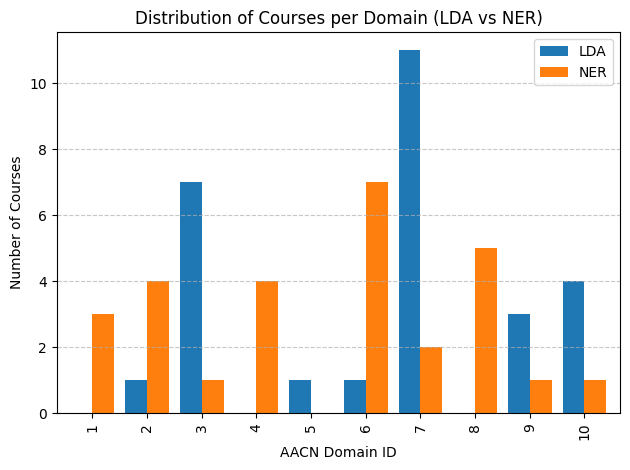

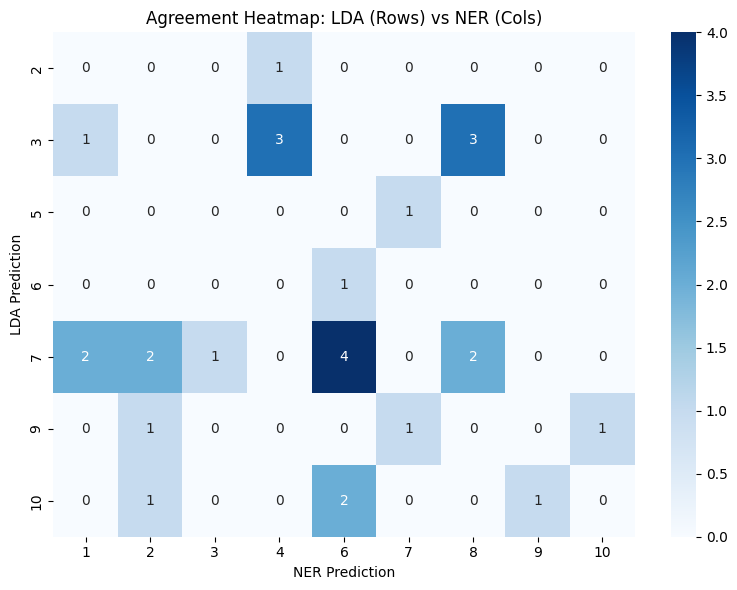

In [ ]:
# generating extra visualizations for report and presentation
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

# load data
with open('combined_results.json', 'r') as f:
    results = json.load(f)
df = pd.read_csv('predictions_summary.csv')

print(f"Agreement Rate: {results['metadata']['agreement_rate']:.1%}")
print(f"Avg LDA Confidence: {results['metadata']['avg_lda_confidence']:.3f}")
print(f"Avg NER Confidence: {results['metadata']['avg_ner_confidence']:.3f}")

plt.figure(figsize=(10, 5))
domain_counts = pd.DataFrame({
    'LDA': df['LDA_Domain'].value_counts(),
    'NER': df['NER_Domain'].value_counts()
}).sort_index().fillna(0)

domain_counts.plot(kind='bar', width=0.8)
plt.title('Distribution of Courses per Domain (LDA vs NER)')
plt.xlabel('AACN Domain ID')
plt.ylabel('Number of Courses')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('slide1_chart.png')
plt.show()

plt.figure(figsize=(8, 6))
heatmap_data = pd.crosstab(df['LDA_Domain'], df['NER_Domain'])
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='d')
plt.title('Agreement Heatmap: LDA (Rows) vs NER (Cols)')
plt.ylabel('LDA Prediction')
plt.xlabel('NER Prediction')
plt.tight_layout()
plt.savefig('slide2_heatmap.png')
plt.show()